<a href="https://colab.research.google.com/github/khchoi-physik/pbh_simulations/blob/main/BackgroundMaxSampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Import packages

import cupy as cp
from cupyx.scipy.special import erf

import numpy as np
#import pyfftw
import matplotlib.pyplot as plt
import imageio
import gc
import os
import psutil

#from scipy.special import erf
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import euclidean_distances
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

import h5py

In [2]:
# @title 1 GPU simulation

# @title 1.11 GPU Random field simulations

class GPU_RFSIM:

    def __init__(self, mean, std_dev, pixel, z_pixel, amplitude, k_power, lamb):
        self.mean = mean
        self.std_dev = std_dev
        self.pixel = pixel
        self.z_pixel = z_pixel
        self.amplitude = amplitude
        self.k_power = k_power
        self.lamb = lamb

    def grf_64f(self):
        # 3D Fast Fourier transform of the white noise
        white_noise = cp.random.normal(self.mean, self.std_dev, (self.pixel, self.pixel, self.z_pixel))
        #print(f"white_noise allocates: {white_noise.nbytes / (1024**2):.2f} MB of memory.")
        #print(f"Total memory usage: {self.get_process_memory():.2f} MB")

        fft_white_noise = cp.fft.fftn(white_noise)
        del white_noise
        #print(f"fft_white_noise allocates: {fft_white_noise.nbytes / (1024**2):.2f} MB of memory.")
        #print(f"Total memory usage: {self.get_process_memory():.2f} MB")

        # Generating FFT momentum
        kx = cp.fft.fftfreq(self.pixel)*self.pixel
        ky = cp.fft.fftfreq(self.pixel)*self.pixel
        kz = cp.fft.fftfreq(self.z_pixel)*self.z_pixel

        kx_grid, ky_grid, kz_grid = cp.meshgrid(kx, ky, kz, sparse = True)
        del kx, ky, kz
        # Genearting FFT momentum 3D array
        # Norm of k

        k_norm = cp.sqrt(kx_grid**2 + ky_grid**2  + kz_grid**2)
        k_norm[0][0][0] = cp.inf  # Regularize divergence at k=0
        del kx_grid, ky_grid, kz_grid
        #print(f"k_norm allocates: {k_norm.nbytes / (1024**2):.2f} MB of memory")
        #print(f"Total memory usage: {self.get_process_memory():.2f} MB")

        # Power Spectrum P_k
        power_spectrum = (self.amplitude*(((2*cp.pi/self.pixel)*k_norm)**(-1*self.k_power)))  # P(k)=amplitude/k^{power},
        del k_norm
        #print(f"power_spectrum allocates: {power_spectrum.nbytes / (1024**2):.2f} MB of memory")
        #print(f"Total memory usage: {self.get_process_memory():.2f} MB")

        # Multiply the power spectrum with the transformed white noise to get the realization of the spectrum
        fourier_amplitudes_sqrt =  cp.sqrt(power_spectrum, out=power_spectrum)*fft_white_noise
        del power_spectrum, fft_white_noise
        #print(f"fourier_amplitudes_sqrt allocates: {fourier_amplitudes_sqrt.nbytes / (1024**2):.2f} MB of memory")
        #print(f"Total memory usage: {self.get_process_memory():.2f} MB")

        # Perform inverse Fourier transform to obtain the Gaussian random field in the spatial domain
        gaussian_random_field = cp.fft.ifftn(fourier_amplitudes_sqrt).real
        del fourier_amplitudes_sqrt
        gc.collect()
        #print(f"gaussian_random_field allocates: {gaussian_random_field.nbytes / (1024**2):.2f} MB of memory")

        # Final estimation of memory usage
        #print(f"Total memory usage: {self.get_process_memory():.2f} MB")

        return gaussian_random_field


    def gaussian_to_exp(self, grf):
        grf_mean = cp.mean(grf)
        grf_std_dev = cp.std(grf)
        xu = 0.5 * (1 + erf((grf - grf_mean) / (cp.sqrt(2) * grf_std_dev)))

        gc.collect()

        exprf = -1/self.lamb  * cp.log(1 - xu)

        return exprf

1 GPU Simulations

In [3]:
# @title 1.31 CPU Data Analysis
class CPU_MAX_SAMPLING:

    def __init__(self, exprf, pixel, z_pixel):
        self.pixel = pixel
        self.z_pixel = z_pixel
        self.exprf = exprf


    def max_sub_exprfs(self, lx, ly, lz, x, y, z):

        x_min, x_max = max(x-lx,0), min(x+lx +1, self.pixel)
        y_min, y_max = max(y-ly,0), min(y+ly +1, self.pixel)
        z_min, z_max = max(z-lz,0), min(z+lz +1, self.z_pixel)

        sub_exprf = self.exprf[x_min:x_max, y_min:y_max, z_min:z_max]
        max_sub_exprf = np.max(sub_exprf)

        del sub_exprf

        return np.max(max_sub_exprf)

In [4]:
# @title Mount gdrive and directory
from google.colab import drive
drive.mount('/content/gdrive/')
folder_path = '/content/gdrive/MyDrive/2023 RFSimulations/simulated_field'
os.chdir(folder_path)
print("Current Working Directory:", os.getcwd())

Mounted at /content/gdrive/
Current Working Directory: /content/gdrive/MyDrive/2023 RFSimulations/simulated_field


In [5]:
# @title Background signal differentiation


#instance_id_list = [23898, 32860, 35693, 40640, 43753, 62221]
#gpu_id_list = [0,1,0,0,1,3]

k_power = 1
l= 5
lx, ly, lz = l,l,l

pixel = 2**9
z_pixel = pixel

max_pixel = int((pixel//(2*l+1))-1)*(2*l+1)
# initialization
rfsim = GPU_RFSIM(mean=0, std_dev=1, pixel=pixel, z_pixel=z_pixel, amplitude=1.0, k_power=k_power, lamb=1.0)

for _ in range(250):
    grf = rfsim.grf_64f()
    exprf = rfsim.gaussian_to_exp(grf)
    del grf

    exprf = cp.asnumpy(exprf)

    max_amplitude_list = []

    #exprf = np.load(f'exprf_{instance_id}_gpu{gpu_id}.npy')
    #threshold = 15*np.std(exprf)

    cpu_max_sampling = CPU_MAX_SAMPLING(exprf=exprf, pixel=pixel, z_pixel= z_pixel)

    for x in range(lx+1, max_pixel, 2*lx):
        for y in range(ly+1,  max_pixel, 2*ly):
            for z in range(lz+1, max_pixel, 2*lz):

                max_amplitude_list.append(cpu_max_sampling.max_sub_exprfs(lx, ly, lz, x, y, z))

<ipython-input-11-5e9bf62f5b2e>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


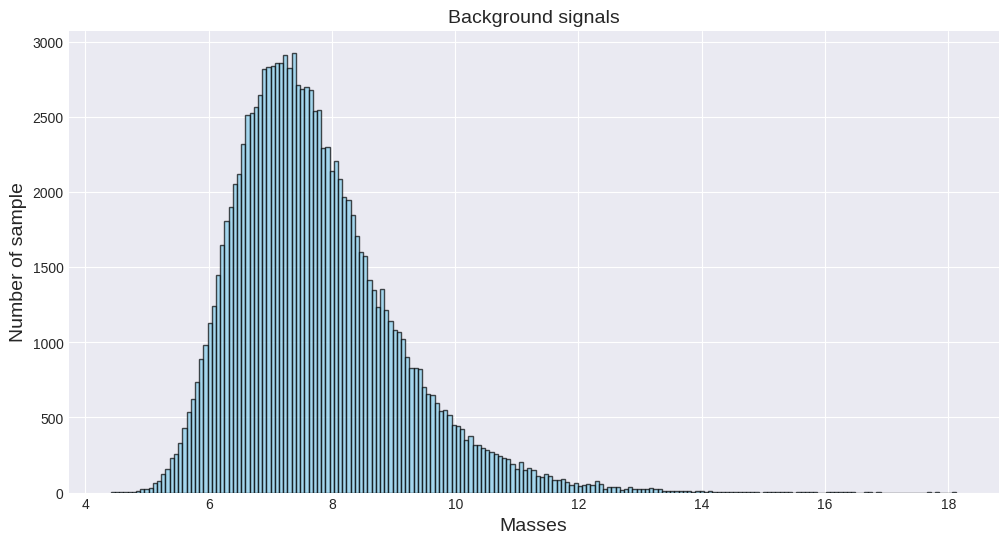

In [11]:
save_path = f'/content/gdrive/MyDrive/2023 RFSimulations/simulated_results/k_{k_power}/'
os.chdir(save_path)

plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(1,1,1)

ax.hist(max_amplitude_list, bins= 201, color= 'skyblue', edgecolor = 'black', alpha=0.7)
ax.set_xlabel('Masses', fontsize = 14)
ax.set_ylabel('Number of sample', fontsize = 14)
ax.set_title('Background signals', fontsize = 14)
ax.grid(True)
plt.show

fig.savefig(f'Background_signal_max_amplitude_k_{k_power}_l_{l}.pdf')
np.save(f'Background_signal_max_amplitude_k_{k_power}_l_{l}.npy', max_amplitude_list)

In [12]:
import numpy as np
import scipy as sp
 #import pyfftw
import matplotlib.pyplot as plt
import imageio
import gc
import os
import psutil

def gumbel(x,mu,beta):

    z = (x-mu) / beta
    gumbel_pdf = beta**(-1) * np.exp(-(z + np.exp(-z) ) )

    return gumbel_pdf

In [13]:
# @title Mount gdrive and directory
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [25]:
import os
import numpy as np

k_power = 1
l = 5

load_path = f'/content/gdrive/MyDrive/2023 RFSimulations/simulated_results/k_{k_power}'
os.chdir(load_path)

max_data = np.load(f'Background_signal_max_amplitude_k_{k_power}_l_{l}.npy')

In [26]:
counts, bins = np.histogram(max_data, density =True, bins= 200)

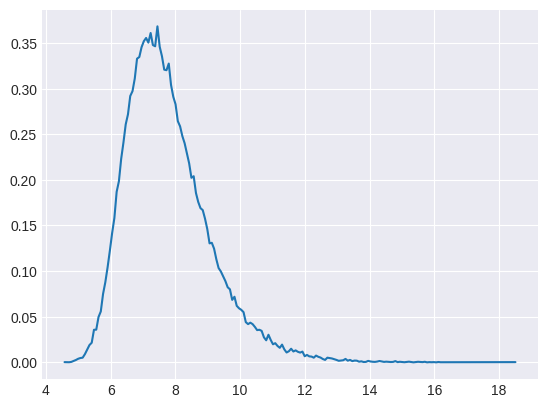

In [27]:
plt.plot(bins[1:],counts)

In [28]:
sp.optimize.curve_fit(gumbel, bins[1:], counts)

(array([7.1955899 , 1.03187895]),
 array([[6.47446712e-06, 1.02701609e-06],
        [1.02701609e-06, 4.47234564e-06]]))

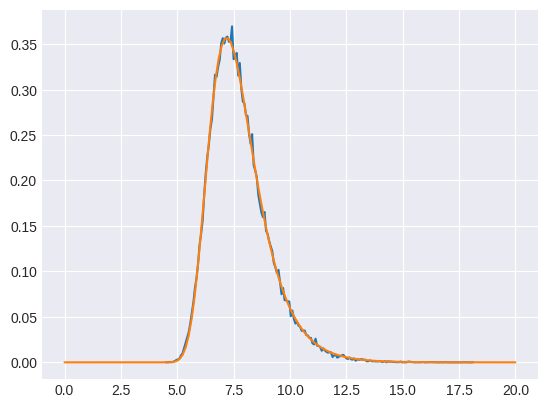

In [19]:
# @title k=3
plt.plot(bins[1:],counts)
xrange = np.linspace(0, 20, 150)
plt.plot(xrange, gumbel(xrange, 7.19165822 , 1.03037473))

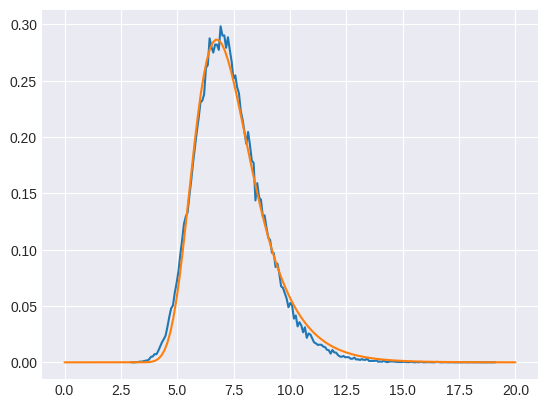

In [24]:
# @title k=2
plt.plot(bins[1:],counts)
xrange = np.linspace(0, 20, 150)
plt.plot(xrange, gumbel(xrange, 6.75271302 , 1.28332025))

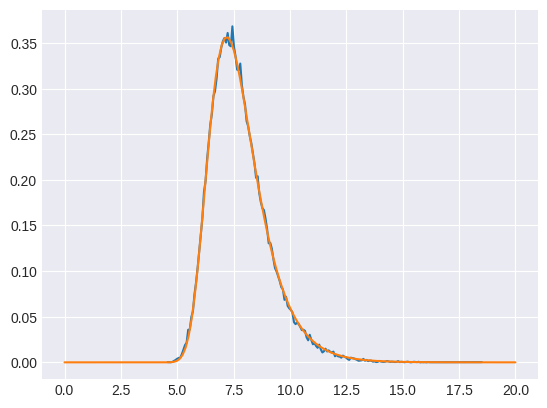

In [29]:
# @title k=2
plt.plot(bins[1:],counts)
xrange = np.linspace(0, 20, 150)
plt.plot(xrange, gumbel(xrange, 7.1955899 , 1.03187895))